# Introduction

This notebook analyzes data collected from a French Bakery (dataset available on kaggle). The dataset provides the daily transaction details of customers from 2021-01-01 to 2022-09-30.

Key Questions:
- What is the profile of sales during the day? the week? the year?
- How do different scenarios impact the likelihood of accepting a coupon?
- Focus on Bar coupon and Coffee House coupon

Let's delve into the data exploration and analysis to uncover insights into driver behavior regarding coupon acceptance.

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from matplotlib.colors import to_hex
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL

# Data loading and overview 

In [2]:
data = pd.read_csv('data/Bakery sales.csv')

In [3]:
data

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"
...,...,...,...,...,...,...,...
234000,511387,2022-09-30,18:52,288911.0,COUPE,1.0,"0,15 €"
234001,511388,2022-09-30,18:52,288911.0,BOULE 200G,1.0,"1,20 €"
234002,511389,2022-09-30,18:52,288911.0,COUPE,2.0,"0,15 €"
234003,511392,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,"1,30 €"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     234005 non-null  int64  
 1   date           234005 non-null  object 
 2   time           234005 non-null  object 
 3   ticket_number  234005 non-null  float64
 4   article        234005 non-null  object 
 5   Quantity       234005 non-null  float64
 6   unit_price     234005 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 12.5+ MB


In [5]:
#checking the different values of columns to see any problematic data
data['article'].value_counts()

article
TRADITIONAL BAGUETTE        67689
COUPE                       20470
BAGUETTE                    15292
BANETTE                     15130
CROISSANT                   11508
                            ...  
PAIN NOIR                       1
BUCHE 8PERS                     1
CRUMBLECARAMEL OU PISTAE        1
DOUCEUR D HIVER                 1
SACHET DE VIENNOISERIE          1
Name: count, Length: 149, dtype: int64

In [6]:
# Count missing values in each column
missing_data_count = data.isnull().sum()
print(missing_data_count)

Unnamed: 0       0
date             0
time             0
ticket_number    0
article          0
Quantity         0
unit_price       0
dtype: int64


# Data cleaning & Preprocessing

There is 234005 entries

In [7]:
# deletion of the useless column car
data = data.drop('Unnamed: 0', axis=1)

In [8]:
# Remove '€' and replace ',' with '.'
data['unit_price'] = data['unit_price'].str.replace('€', '').str.replace(',', '.')

# Convert to numeric
data['unit_price'] = pd.to_numeric(data['unit_price'])

In [9]:
# Remove rows where price is 0 
data = data.query('unit_price != 0 ')

In [10]:
# Convert 'time' to datetime
data['date'] = pd.to_datetime(data['date'])
data['time'] = pd.to_datetime(data['time'], format='%H:%M')

# Add weekday 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['weekday'] = data['date'].dt.day_name()
data['weekday'] = pd.Categorical(data['weekday'], categories=weekday_order, ordered=True)

# Add month 
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data['month'] = data['date'].dt.month_name()
data['month'] = pd.Categorical(data['month'], categories=month_order, ordered=True)


In [11]:
# Total price
data['total_price'] = data['unit_price']*data['Quantity']

In [12]:
# Removing of duplicates
data = data.drop_duplicates()

In [13]:
len(data)

232763

In [14]:
len(data[data['Quantity']<0])

1283

In [15]:
# Removing of the initial transactions and their refund which do not enter in the revenue 
# Selection of all refunds
data_negative = data[data['Quantity'] < 0]
# Dataset for only refund and their associated initial transaction
data_refunds = pd.DataFrame([])
print(len(data_negative))

1283


In [16]:
# Initialize data_no_refunds as a copy of the original data
data_no_refunds = data.copy()
attempts_total = []

# this function search for transaction which is the opposite of the target (refund) and remove it from the dataset
def remove_refund_initial_tx(data, data_ref, row):
    attempts = 1
    max_attempts = 200  # Set your desired maximum attempts
    filtered_rows = []
    # Start a while loop to keep trying until a matching row is found or a maximum number of attempts is reached
    while attempts < max_attempts and len(filtered_rows) == 0:
        # Define the condition for filtering rows
        condition = (
            'Quantity == ' +str(-row['Quantity'])+' and '
            +'article == "' +str(row['article']) +'" and '
            +'total_price == ' +str(-row['total_price']) +' and '
            +'ticket_number == ' +str(row['ticket_number'] - attempts)
        )

        # Apply boolean indexing to filter rows
        filtered_rows = data.query(condition)
        filtered_rows['refund_ticket_number'] = row['ticket_number']
        filtered_rows['date_ticket_number'] = row['date']
        filtered_rows['time_ticket_number'] = row['time']
        filtered_rows['type'] = 'initial'
        filtered_rows = filtered_rows.reset_index()
        data_ref = pd.concat([data_ref, filtered_rows])
        attempts_total.append(attempts)
        attempts +=1
    
    if(len(filtered_rows)>1):
        print('problem')
        print(filtered_rows)
    # Update data_no_refunds with the filtered rows
    data_no_refunds = data.query('~ ('+condition+')')  # Exclude the matching rows
    return data_no_refunds, data_ref

# Loop through each refund
for index, row in data_negative.iterrows():
    # Apply remove_refund_initial_tx function to update data_no_refunds
    data_no_refunds, data_refunds = remove_refund_initial_tx(data_no_refunds, data_refunds, row)

# Deletion of the refunds
data_no_refunds = data_no_refunds[data_no_refunds['Quantity']>0]

if (len(data_no_refunds) == (len(data) - 2*len(data_negative))):
    print('Deletion of refunds and initials transactions proceeded with success')
else:
    print('Deletion of refunds and initials transactions Failed')

/var/folders/v0/cgwrln2d111093wl_kp_tcrw0000gn/T/ipykernel_16555/1223419515.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['refund_ticket_number'] = row['ticket_number']
/var/folders/v0/cgwrln2d111093wl_kp_tcrw0000gn/T/ipykernel_16555/1223419515.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['date_ticket_number'] = row['date']
/var/folders/v0/cgwrln2d111093wl_kp_tcrw0000gn/T/ipykernel_16555/1223419515.py:24: SettingWithCopyWarning: 
A value is trying to be set on a co

Deletion of refunds and initials transactions proceeded with success


/var/folders/v0/cgwrln2d111093wl_kp_tcrw0000gn/T/ipykernel_16555/1223419515.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['refund_ticket_number'] = row['ticket_number']
/var/folders/v0/cgwrln2d111093wl_kp_tcrw0000gn/T/ipykernel_16555/1223419515.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['date_ticket_number'] = row['date']
/var/folders/v0/cgwrln2d111093wl_kp_tcrw0000gn/T/ipykernel_16555/1223419515.py:24: SettingWithCopyWarning: 
A value is trying to be set on a co

In [17]:
# Add categories
category_df = pd.read_csv('data/category.csv')
# Merge the two DataFrames on the 'article' column to add the category column to the datset
cat_data = pd.merge(data_no_refunds, category_df, on='article', how='left')

# Too few sales for these categories to we regroup them together in Other
replacement_dict = {'Miscellaneous': 'Other', 'Candy': 'Other', 'Beverage':'Other'}
cat_data['Category'] = cat_data['Category'].replace(replacement_dict)

# Define the order of categories
category_order = ['Baguette', 'Bread', 'Viennoiserie', 'Savory', 'Pastry', 'Cake & Tart', 'Other']

# Create a CategoricalDtype with the specified order
category_dtype = pd.CategoricalDtype(categories=category_order, ordered=True)

# Apply the CategoricalDtype to the 'Category' column
cat_data['Category'] = cat_data['Category'].astype(category_dtype)

cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230197 entries, 0 to 230196
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           230197 non-null  datetime64[ns]
 1   time           230197 non-null  datetime64[ns]
 2   ticket_number  230197 non-null  float64       
 3   article        230197 non-null  object        
 4   Quantity       230197 non-null  float64       
 5   unit_price     230197 non-null  float64       
 6   weekday        230197 non-null  category      
 7   month          230197 non-null  category      
 8   total_price    230197 non-null  float64       
 9   Category       230197 non-null  category      
dtypes: category(3), datetime64[ns](2), float64(4), object(1)
memory usage: 13.0+ MB


Saving the preprocessed data into a new csv

In [18]:
cat_data.to_csv('data/cleaned_sales.csv', index=False)

In [45]:
# Add weather and holidays
extra_df = pd.read_csv('data/extra1.csv')
extra_df['date'] = pd.to_datetime(extra_df['date'])
# Merge the two DataFrames on the 'date' column to add the temperature and holiday columns to the datset
extra_data = pd.merge(cat_data, extra_df, on='date', how='left')
extra_data.head()

,date,time,ticket_number,article,Quantity,unit_price,weekday,month,total_price,Category,Temperature,Holiday
0,2021-01-02,1900-01-01 08:38:00,150040.0,BAGUETTE,1.0,0.90,Saturday,January,0.90,Baguette,2,Regular day
1,2021-01-02,1900-01-01 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,Saturday,January,3.60,Viennoiserie,2,Regular day
2,2021-01-02,1900-01-01 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,Saturday,January,2.40,Viennoiserie,2,Regular day
3,2021-01-02,1900-01-01 09:14:00,150041.0,PAIN,1.0,1.15,Saturday,January,1.15,Bread,2,Regular day
4,2021-01-02,1900-01-01 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,Saturday,January,6.00,Baguette,2,Regular day


# Exploratory data analysis

## Global exploration on the complete dataset

What is the sales profile of any baguette or bread during the day? 

In [20]:
extra_data["date"].max() - extra_data["date"].min()
print(extra_data["date"].min())
print(extra_data["date"].max())

2021-01-02 00:00:00
2022-09-30 00:00:00


In [21]:
extra_data["date"].value_counts()

date
2022-08-14    992
2022-07-17    928
2021-08-15    923
2022-07-31    892
2022-08-21    888
             ... 
2021-12-09    160
2022-03-09    157
2022-03-16    143
2021-09-22     55
2022-01-04     47
Name: count, Length: 600, dtype: int64

The Bakery was opened 600 days between the Jan-2-2021 and Sept-30-2022, and was closed 36 days during the same period.

In [22]:
# Usage of same color palette with seaborn or plotly
color_map = {'Baguette':px.colors.qualitative.Pastel2[0],
            'Bread':px.colors.qualitative.Pastel2[1],
            'Viennoiserie':px.colors.qualitative.Pastel2[2],
            'Savory':px.colors.qualitative.Pastel2[3],
            'Pastry':px.colors.qualitative.Pastel2[4],
            'Cake & Tart':px.colors.qualitative.Pastel2[5],
            'Other':px.colors.qualitative.Pastel2[6]}

hex_colors = ['#B3E2CD', '#FDCCAC', '#CBD5E8', '#F4CAE4', '#E6F5C9', '#FFF2AE', '#F1E2CC', '#CCCCCC']

# Set your custom color palette
sns.set_palette(sns.color_palette(hex_colors))

#### What is the sales profile by category during the time of day?

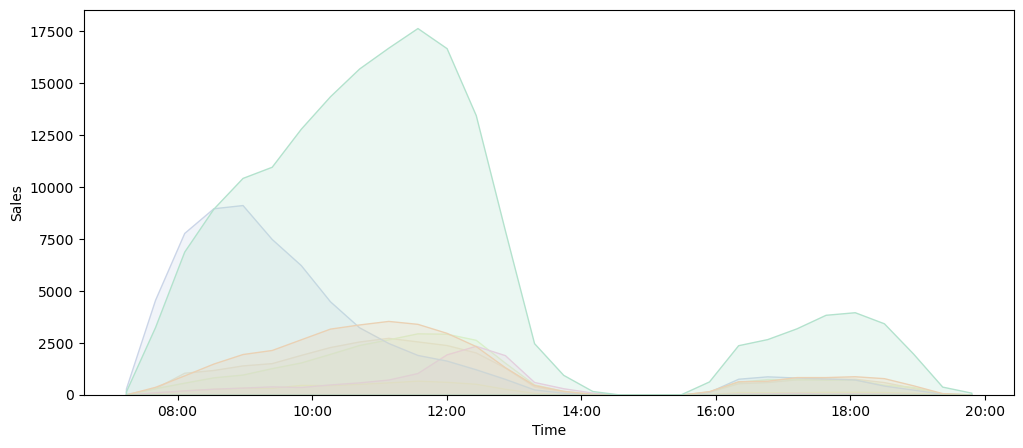

In [23]:
plt.figure(figsize=(12, 5))

# Filter data based on the current selection
selected_data = extra_data.sort_values('time')

# Create a histogram using seaborn with sum of quantity on the y-axis
ax = sns.histplot(data=selected_data, x='time', hue='Category', bins=30, element='poly', weights='Quantity', legend=False)

# Set major locator and formatter for better x-axis ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set labels and title 
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

plt.savefig('images/timeProfile.png', bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

#### What is the sales profile by week day?

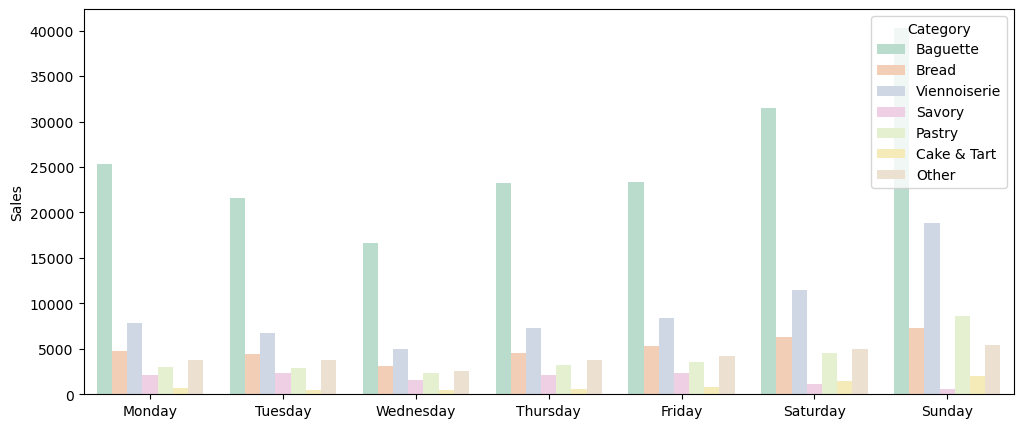

In [24]:
data_by_cat_and_weekday = extra_data[['total_price','Quantity','Category','weekday']].groupby(['Category', 'weekday']).sum().reset_index()

plt.figure(figsize=(12, 5))

# Create a histogram using seaborn with sum of quantity on the y-axis
ax = sns.barplot(data=data_by_cat_and_weekday, x='weekday', y='Quantity', hue='Category')

# Set labels
ax.set_ylabel('Sales')
ax.set_xlabel('')

# Show the plot
plt.show()

#### What is the sales profile per month (only 2021)? 

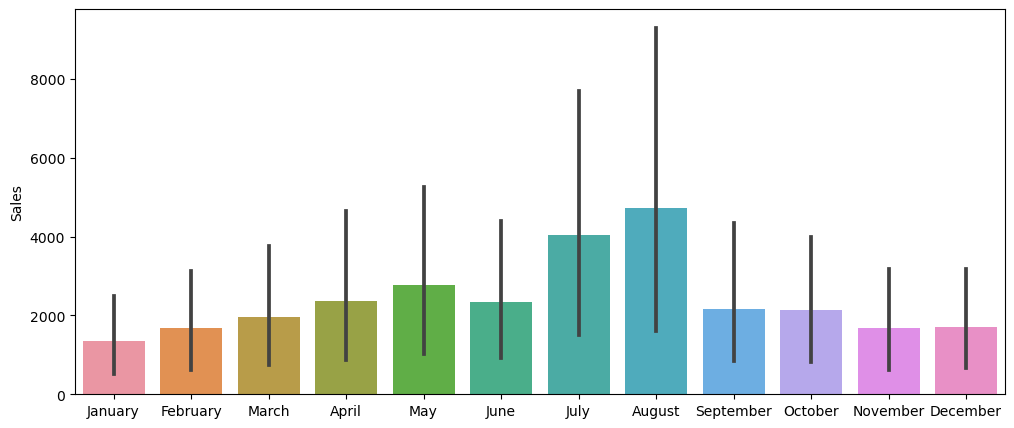

In [25]:
data_by_cat_and_month = extra_data[['total_price','Quantity','Category','month']][extra_data['date']<='2021-12-31'].groupby(['Category', 'month']).sum().reset_index()

plt.figure(figsize=(12, 5))

# Create a histogram using seaborn with sum of quantity on the y-axis
ax = sns.barplot(data=data_by_cat_and_month, x='month', y='Quantity')

# Set labels
ax.set_ylabel('Sales')
ax.set_xlabel('')

plt.savefig('images/monthProfile.png', bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

In [26]:
data_per_date = pd.DataFrame(extra_data['date'].value_counts()).reset_index()
# Add month 
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data_per_date['date'] = pd.to_datetime(data_per_date['date'])
data_per_date['month'] = data_per_date['date'].dt.month_name()
data_per_date['month'] = pd.Categorical(data_per_date['month'], categories=month_order, ordered=True)
data_per_date = data_per_date[data_per_date['date']<'2022-01-01']
data_per_date
data_per_date2 = pd.DataFrame(data_per_date['month'].value_counts()).reset_index()
data_per_date2.sort_values('month')


,month,count
8,January,26
11,February,24
9,March,26
5,April,29
7,May,27
3,June,30
0,July,31
1,August,31
4,September,30
2,October,31


#### What is the Revenue distribution per Category?

In [27]:
data_by_cat = extra_data[['Category','Quantity','total_price']].groupby('Category').sum()
data_by_cat = data_by_cat.reset_index().sort_values('Category')
data_by_cat

,Category,Quantity,total_price
0,Baguette,182119.0,210883.70
1,Bread,35868.0,66598.70
2,Viennoiserie,65506.0,84598.05
3,Savory,12293.0,72931.57
4,Pastry,28021.0,60197.45
5,Cake & Tart,6412.0,51822.00
6,Other,28495.0,10732.98


In [28]:

fig = px.pie(data_by_cat, 
             values='total_price', 
             names='Category',
             color_discrete_sequence=px.colors.qualitative.Pastel2,
             category_orders={'Category': list(color_map.keys())},
            # color_discrete_map=color_map,
             hole=.3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update(layout_showlegend=False)
fig.update_layout(height=500, width=500, paper_bgcolor='rgba(0,0,0,0)') 
fig.show()
# Save the plot as a PNG image
pio.write_image(fig, 'images/distribution_by_category.png')

#### What is the average transaction?

In [29]:
total_per_ticket = extra_data[extra_data['date']<'2022-01-01'].groupby('ticket_number').agg({'Quantity': 'sum', 'total_price': 'sum'}).reset_index()
total_per_ticket.describe()

,ticket_number,Quantity,total_price
count,75444.000000,75444.000000,75444.000000
mean,188646.830868,2.684190,4.027767
std,22203.534363,2.328421,4.289845
min,150040.000000,1.000000,0.150000
25%,169512.750000,1.000000,1.200000
50%,188659.500000,2.000000,2.400000
75%,207804.250000,3.000000,4.950000
max,227279.000000,87.000000,199.700000


In [30]:
total_per_ticket['Quantity'].mean()

2.684189597582313

In [31]:
total_per_ticket['total_price'].mean()

4.027766555325805

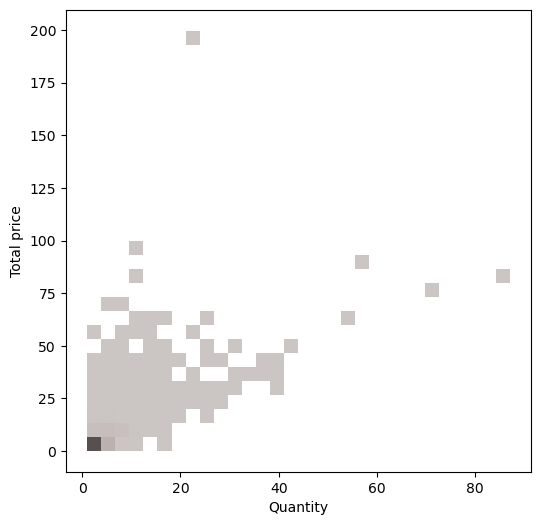

In [32]:

hex_colors = ['#807370', '#FDCCAC', '#CBD5E8', '#F4CAE4', '#E6F5C9', '#FFF2AE', '#F1E2CC', '#CCCCCC']
# Set your custom color palette
sns.set_palette(sns.color_palette(hex_colors))

plt.figure(figsize=(6,6))

# Create a histogram using seaborn with sum of quantity on the y-axis
ax = sns.histplot(total_per_ticket, x='Quantity', y='total_price', bins=30)


# Set labels
ax.set_ylabel('Total price')
#ax.set_xlabel('')
plt.savefig('images/Average ticket.png', bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

Average transaction : 2.7 items for 4.1 euros